# MRAC Ship Simulation with McGym 
This notebook runs a simulation of a marine craft using a combined MRAC heading and surge PID controller within the `McGym` environment. It includes profiling to identify performance bottlenecks.

## 1. Imports and Dependencies
Import all required modules and set up the environment.

In [1]:
from numpy_core.gym.mc_gym_csad_numpy import McGym
from numpy_core.controllers.adaptive_seakeeping import MRACShipController
from mclsimpy.utils import Rz, six2threeDOF, three2sixDOF
import numpy as np
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 2. Define a Moving Goal and Obstacle Function 
This example defines a goal that wiggles over time. You can set `goal_func=None` to use a static goal, and same holds for the obstical.
This example shows that you can have several obsticals too.

In [2]:
def goal_func(t):
    """Wiggles the goal position over time."""
    north0, east0, size0 = 4, 12, 1
    new_north = north0 + 1.0 * np.sin(0.2 * t)
    new_east  = east0  + 0.5 * np.cos(0.1 * t)
    return (new_north, new_east, size0)
    
def obstacle_func(t):
    """
    Returns a list of moving obstacles for time t.
    In this example, one obstacle circles around (2,7) with radius 1m,
    and another slides back and forth along the east axis.
    """
    # Obstacle 1: circular motion around (2, 7)
    center_n, center_e = 2.0, 7.0
    radius = 1.0
    omega1 = 0.2  # angular speed [rad/s]
    obs1_n = center_n + radius * np.cos(omega1 * t)
    obs1_e = center_e + radius * np.sin(omega1 * t)
    
    # Obstacle 2: sinusoidal east–west motion at fixed north = 4
    base_n = 4.0
    amp = 1.5
    omega2 = 0.1
    obs2_n = base_n
    obs2_e = 10.0 + amp * np.sin(omega2 * t)
    
    # All obstacles have diameter 1.0
    diameter = 1.0
    
    return [
        (obs1_n, obs1_e, diameter),
        (obs2_n, obs2_e, diameter)
    ]


## 3. Environment Configuration
Initialize the `McGym` environment with wave conditions, start position, goal, and obstacles.

In [3]:
# Simulation time step
dt = 0.08 

# Create environment
env = McGym(
    dt=dt,
    grid_width=15,
    grid_height=6,
    render_on=True,
    final_plot=True
)

# Initial setup
start_pos = (2, 2, 90)          # Start at (north=2, east=2), heading 90°
wave_conditions = (0.05, 1.5, 0)  # (Hs, Tp, wave_dir)
initial_goal = (4, 12, 1)
initial_obstacles = [(2, 7, 1.0)]

env.set_task(
    start_position=start_pos,
    goal=initial_goal,
    wave_conditions=wave_conditions,
    obstacles=initial_obstacles,
    goal_func=None,
    obstacle_func=None,
    position_tolerance=0.5,
    goal_heading_deg=90.0,
    heading_tolerance_deg=40.0
)

***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************


## 4. Controller Initialization
Create the MRAC ship controller.

In [4]:
# Create the MRAC-based controller
controller = MRACShipController(dt=dt)

## 5. Run the Simulation Loop
Step through the environment, compute control actions, and print the termination info message when done.

In [5]:
# Total simulation time
simtime = 150.0
max_steps = int(simtime / dt)

print("Starting simulation...")
start_time = time.time()

for step_count in range(max_steps):
    state = env.get_state()
    goal_n, goal_e, _ = state["goal"]
    action = controller.compute_action(state, (goal_n, goal_e))
    new_state, done, info, reward = env.step(action)

    # Optional distance check
    boat_n, boat_e, yaw = six2threeDOF(new_state["eta"])
    distance_to_goal = np.sqrt((goal_n - boat_n)**2 + (goal_e - boat_e)**2)
    if distance_to_goal < 0.5:
        print(f"Close to goal at step {step_count}, distance={distance_to_goal:.2f}")

    if done:
        # Print the info message from the environment
        reason = info.get('reason', 'unknown')
        print(f"Environment returned done; reason: {reason}. Stopping simulation.")
        break

total_time = time.time() - start_time
print(f"Wall-clock time: {total_time:.2f} s")
print(f"Simulation speed: {(simtime / total_time):.2f}x real-time")

Starting simulation...


/home/kmroen/projects/McHorcrux/numpy_core/gym/mc_gym_csad_numpy.py:503: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(obs_center - p1, seg) / np.dot(seg, seg)


Goal reached!
Close to goal at step 739, distance=0.50
Environment returned done; reason: goal_reached. Stopping simulation.
Wall-clock time: 15.08 s
Simulation speed: 9.95x real-time


## 6. Trajectory Plot
After the simulation, plot the boat trajectory if `final_plot=True`.

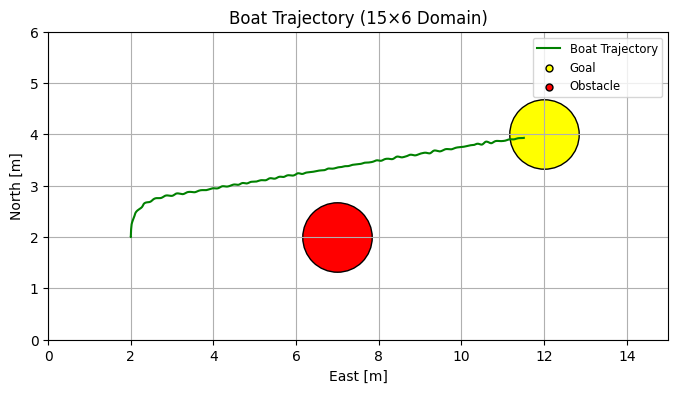

In [6]:
env.plot_trajectory()
env.close() #do not need in a .py, but needed in a jupyter notebook

## With moving goal and obsticals 

In [7]:
# Initial setup
dt = 0.08 
start_pos = (2, 2, 90)          # Start at (north=2, east=2), heading 90°
wave_conditions = (0.05, 1.5, 0)  # (Hs, Tp, wave_dir)

# Create environment
env2 = McGym(
    dt=dt,
    grid_width=15, #the length of the mc-lab mocap
    grid_height=6, #the width of the mc-lab mocap
    render_on=True,
    final_plot=True
)
# Reset environment with moving goal and moving obstacles
env2.set_task(
    start_position=start_pos,
    wave_conditions=wave_conditions,
    goal_func=goal_func,
    obstacle_func=obstacle_func,
    position_tolerance=0.5,
    goal_heading_deg=90.0,
    heading_tolerance_deg=40.0
)

simtime = 150.0
max_steps = int(simtime / dt)

print("Starting simulation with moving goal and obstacles...")
start_time = time.time()

for step_count in range(max_steps):
    state = env2.get_state()
    # Use the goal from the moving goal function
    goal_n, goal_e, _ = state["goal"]
    action = controller.compute_action(state, (goal_n, goal_e))
    new_state, done, info, reward = env2.step(action)

    boat_n, boat_e, yaw = six2threeDOF(new_state["eta"])
    distance_to_goal = np.sqrt((goal_n - boat_n)**2 + (goal_e - boat_e)**2)
    if distance_to_goal < 0.5:
        print(f"Close to goal at step {step_count}, distance={distance_to_goal:.2f}")

    if done:
        print(f"Simulation ended at step {step_count}; reason: {info.get('reason', 'unknown')}.")
        break

total_time = time.time() - start_time
print(f"Wall-clock time: {total_time:.2f} s")
print(f"Simulation speed: {(simtime / total_time):.2f}x real-time")

***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************
Starting simulation with moving goal and obstacles...
Collision with obstacle #0 at (2.17, 6.01) via edge!
Simulation ended at step 304; reason: collision.
Wall-clock time: 8.40 s
Simulation speed: 17.85x real-time


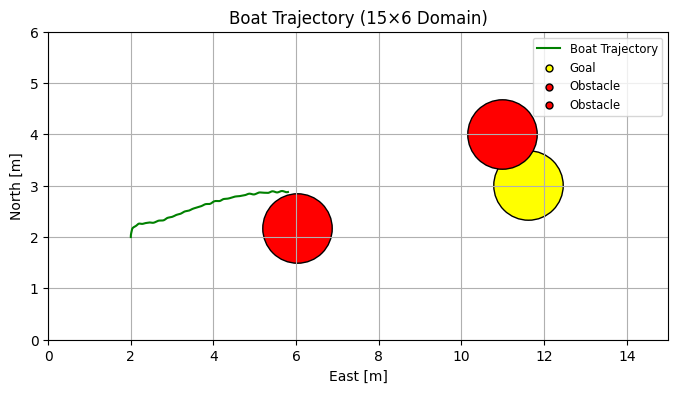

In [8]:
env2.plot_trajectory()
env2.close() #do not need in a .py, but needed in a jupyter notebook